# Solving Inverse Problems - Linear Example

Consider a scenario where we have some observed output data, and our goal is to determine the underlying conditions (inputs) that led to these outcomes.

This can be accomplished by performing experiments to obtain some sample inputs and ouputs, using twinlab to train a model on the data, and applying twinlab's `Emulator.calibrate` function to predict the missing inputs.

First, import the required libraries.

In [2]:
# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Project import
import twinlab as tl


          ====== TwinLab Client Initialisation ======
          Version     : 2.3.0
          Server      : https://twinlab.digilab.co.uk



In [3]:
tl.set_api_key("YOUR-API-KEY")

## Establish Parameters and Create Datasets

We want to establish data and model parameters, and also generate the noisy observed and experimental data.

In [4]:
# Data and model parameters
random_seed = 8675309
err_sig = 2/3

In order to solve an inverse problem (using MCMC behind the scenes), there are a few essential ingredients.

**An observation**: The algorithm computes a posterior distribution of the inputs that is most likely to have resulted in an observation. To begin with, we need to have an observation that we are interested in.

**The standard deviation of the observation**: one of the assumptions in solving a Bayesian inverse problem is that the measurement error/noise level of the observation is known. This may come from the known precision of a sensor module, or multiple measurements can be taken and the mean and standard deviation provided instead.

In our example, we can simply choose a noise level to add to the observation.

In [5]:
# Observed datapoint we would like to know the inputs for.
obs = pd.DataFrame({'y': [10.25]})
display(obs)
obs_std = pd.DataFrame({'y': [err_sig]})
display(obs_std)

,y
0,10.25


,y
0,0.666667


We need a forward model before we can start solving calibration problems. Let's imagine we've sampled from our simulation, done some experiments, or collected some data:

In [6]:
# Seed the random-number generator
np.random.seed(random_seed)

# Create a linear function to generate experimental data
def f(x):
    return 2 * x + 3

# Add Gaussian noise to the linear ouput
def model(X):
    return np.random.normal(f(X), err_sig)

# Set up experimental data dataframe
X = np.linspace(0,10,21)
y = model(X)
df_exp = pd.DataFrame({"X": X, "y": y})
display(df_exp)

# Upload the dataset to the cloud
dataset = tl.Dataset("inverse-methods-dataset")
dataset.upload(df_exp)

,X,y
0,0.0,3.392682
1,0.5,4.488746
2,1.0,4.225207
3,1.5,5.628789
4,2.0,6.485008
5,2.5,7.887852
6,3.0,8.722331
7,3.5,9.081046
8,4.0,11.499504
9,4.5,12.119256


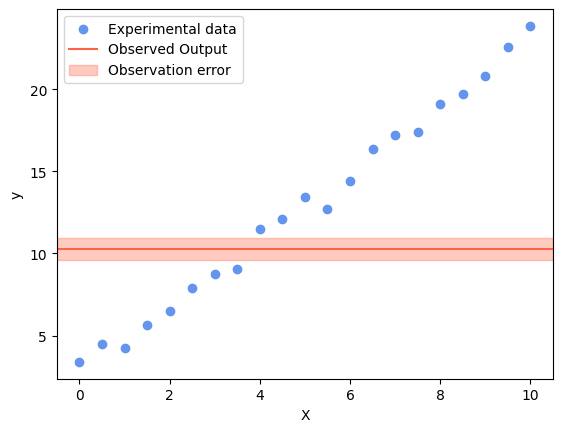

In [7]:
# Plotting routine
def plot_data(X, y, obs=None, obs_std=None, inverse_df=None):
    fig, ax = plt.subplots()
    ax.scatter(X,y, color="cornflowerblue", label="Experimental data")
    if (obs is not None) and (inverse_df is None):
        y_mean = obs['y'][0]
        ax.axhline(y=y_mean, color="tomato", label="Observed Output")
        if obs_std is not None:
            y_std = obs_std['y'][0]
            ax.axhspan(ymin=y_mean-y_std, ymax=y_mean+y_std, color="tomato", alpha=1/3, label="Observation error")
    elif (obs is not None) and (obs_std is not None) and (inverse_df is not None):
        y_mean = obs['y'][0]
        y_std = obs_std['y'][0]
        X_mean = inverse_df["mean"][0]
        X_std = inverse_df["sd"][0]
        ax.scatter(X_mean, y_mean, color="tomato", label="Observed data")
        ax.add_patch(patches.Ellipse((X_mean,y_mean), X_std*2, y_std*2, color="tomato", alpha=1/3, label="Uncertainty"))
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    plt.legend()
    plt.show()
    plt.close()

# Plot the data
plot_data(X=X, y=y, obs=obs, obs_std=obs_std)

## Training the Model

In this section, we'll be establishing the model training parameters, training our model on our experimental data, and producing the output of that training and prediction.

First we need to establish what criteria our model training has. We do this via a `TrainParams` and `Emulator` object, which will include what we want to name our model, specify what the model inputs and outputs are, and fine-tune modelling parameters, such as the test_train_ratio.

In [8]:
# Training parameters
train_params = tl.TrainParams(train_test_ratio=0.8)

Next, we can actually train our model in the Cloud.

In [9]:
# Train model
emulator = tl.Emulator("inverse-methods-model")
emulator.train(dataset, ['X'], ['y'], train_params)

## Inverse Problem

Solve the inverse problem to obtain information about the input value that created the observed output value.

In [10]:
# Solve the inverse problem
inverse_df = emulator.calibrate(obs, obs_std)

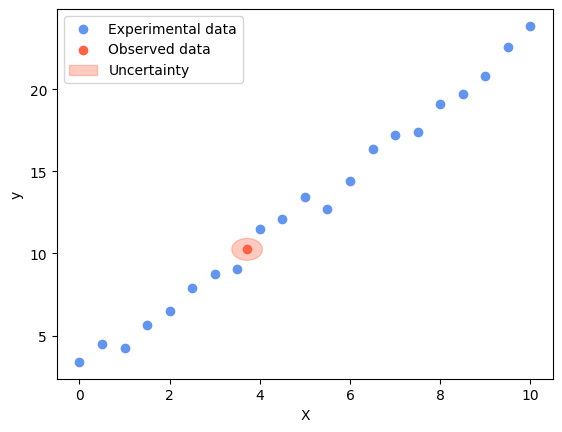

In [11]:
# Plot the data
plot_data(X=X, y=y, obs=obs, obs_std=obs_std, inverse_df=inverse_df)

## Validate Expected Result

Since we fabricated the experimental data, we can manually validate our computed result. Note this is a sanity check and would not be possible with real-world data of an unknown model.

$$
\begin{align}
    y = 2X+3 \;\;\;\rightarrow \;\;\; \frac{y-3}{2} = X
\end{align}
$$

The difference between the computed inverse model mean and X in above equation (1) should be less than the determined standard deviation.

In [12]:
inverse_mean = inverse_df["mean"][0]
inverse_std = inverse_df["sd"][0]
y_obs = obs["y"][0]

actual_X = (y_obs - 3) / 2
difference = abs(actual_X - inverse_mean)

if difference <= inverse_std:
    print(f"Success! The difference between the inverse model mean X ({inverse_mean}) and the algebraically computed X ({actual_X}) is {round(difference, 5)} which is less than the inverse model standard deviation of {inverse_std}.")
else:
    print(f"Something went wrong! The difference between the inverse model mean X ({inverse_mean}) and the algebraically computed X ({actual_X}) is {round(difference, 5)} which is greater than the inverse model standard deviation {inverse_std}.")

Success! The difference between the inverse model mean X (3.719) and the algebraically computed X (3.625) is 0.094 which is less than the inverse model standard deviation of 0.34.


## Finishing up

This section covers how to delete your trained model and dataset from the cloud. Note that you don't need to delete your model and data to rerun a campaign or dataset of the same name--if, say, you rerun the functions above as-is, with no name changes, will simply overwrite your existing model and dataset on the Cloud.

In [13]:
# Delete campaign and dataset if necessary
dataset.delete()
emulator.delete()